In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
import re
from sklearn.linear_model import Ridge
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
trade_df = pd.read_csv('first_round_train_market_data.csv')
fundamental_df  = pd.read_csv('first_round_train_fundamental_data.csv')
ret_df = pd.read_csv('first_round_train_return_data.csv')

### 处理数据字段 <br>

In [3]:
fundamental_df.loc[:,'stk'] = fundamental_df.date_time.apply(lambda x:x.split('d',1)[0])
fundamental_df.loc[:,'date'] = fundamental_df.date_time.apply(lambda x:int(x.split('d',1)[1]))

ret_df.loc[:,'stk'] = ret_df.date_time.apply(lambda x:x.split('d',1)[0])
ret_df.loc[:,'date'] = ret_df.date_time.apply(lambda x:int(x.split('d',1)[1]))

In [4]:
trade_df.loc[:,'stk'] =  trade_df.date_time.apply(lambda x:x.split('d',1)[0])
trade_df.loc[:,'date_'] =trade_df.date_time.apply(lambda x:x.split('d',1)[1])
trade_df.loc[:,'date'] =trade_df.date_.apply(lambda x:int(x.split('p',1)[0]))
trade_df.loc[:,'time'] = trade_df.date_.apply(lambda x:int(x.split('p',1)[1]))

### 处理日内特征值 <br>
#### 扩展成 日内分钟收益波动率、日级别短期动量等特征值 <br>

In [5]:
trade_df.loc[:,'low_high'] = (trade_df['high'] / trade_df['low'])-1
trade_df.loc[:,'chg_Min'] = (trade_df['close'] / trade_df['open'])-1

In [6]:
day_chg = trade_df.groupby(['stk','date']).chg_Min.sum().reset_index()
day_chg.columns = ['stk','date','chg']

Vol_Inday = trade_df.groupby(['stk','date']).low_high.std().reset_index()
Vol_Inday.columns = ['stk','date','Vol_Inday']

Skew_Inday = trade_df.groupby(['stk','date']).chg_Min.skew().reset_index()
Skew_Inday.columns = ['stk','date','Skew_Inday']

AmtStd_Inday = trade_df.groupby(['stk','date']).money.std().reset_index()
AmtStd_Inday.columns = ['stk','date','AmtStd_Inday']

### 处理日间因子 <br>
#### Momentun、reverse、ROE、PB、PE、Vol、Vol_Inday、Skew_Inday、AmtStd_Inday、turnoverRatio<br>

In [7]:
stk_ls = np.unique(day_chg.stk)
ls = []
for code in stk_ls:
    stk_series =  day_chg[day_chg.stk==code].copy()
    stk_series.chg = np.log(stk_series.chg+1)
    stk_series.loc[:,'Trand'] = stk_series.chg.rolling(252).sum()
    stk_series.loc[:,'Reverse'] = stk_series.chg.rolling(21).sum()
    stk_series.loc[:,'Momentum'] = stk_series.Trand - stk_series.Reverse
    ls.append(stk_series[['stk','date','Momentum','Reverse']])
    pass
df_M = pd.concat(ls, ignore_index=True)

In [8]:
fundamental_df.loc[:,'ROE'] = fundamental_df.pb / fundamental_df.pe_ttm

In [9]:
ls_PETS = []
for code in stk_ls:
    
    stk_series_fundamental =  fundamental_df.loc[(fundamental_df.stk==code),('stk','date','pe_ttm')].copy()
    stk_series_fundamental.loc[:,'ts_PE'] = (stk_series_fundamental.pe_ttm - stk_series_fundamental.pe_ttm.rolling(125).mean())\
    /stk_series_fundamental.pe_ttm.rolling(125).std()
    ls_PETS.append(stk_series_fundamental[['stk','date','ts_PE']])
    pass
df_TSPE = pd.concat(ls_PETS, ignore_index=True)

### 合并因子DataFrame <br>

In [10]:
ls = [Vol_Inday, Skew_Inday, AmtStd_Inday, df_M, df_TSPE, fundamental_df]
df = reduce(lambda left,right:pd.merge(left, right, on=['stk','date']),ls)

In [11]:
df.AmtStd_Inday = df.AmtStd_Inday/df.transactionAmount

In [12]:
df_Factor = df[['stk','date','Vol_Inday','AmtStd_Inday','Momentum','Reverse','ts_PE','turnoverRatio','pe_ttm',\
               'ROE','pb','ps','pcf']].copy()
df_Factor = df_Factor.sort_values(by=['date','stk'])
df_Factor = df_Factor[df_Factor.date>251]

### 对因子值进行Z_score <br>

In [13]:
date_index = df_Factor.date.unique()
ls_score = []
for date in date_index:
    cross_df = df_Factor[df_Factor.date==date].copy()
    for j in range(2,cross_df.shape[1]):
        cross_df.iloc[:,j] = (cross_df.iloc[:,j] - cross_df.iloc[:,j].mean())/cross_df.iloc[:,j].std()
        pass
    ls_score.append(cross_df)
    pass
df_score = pd.concat(ls_score, ignore_index=True)

In [14]:
reg_df = pd.merge(df_score, ret_df[['stk','date','return']],on=['date','stk'])

In [15]:
X = np.array(reg_df.iloc[:,2:-1])
y = np.array(reg_df.iloc[:,-1])

In [16]:
X[np.isnan(X)] = 0
X[np.isinf(X)] = 0

In [17]:
reg = Ridge(alpha=1.0).fit(X,y)

In [24]:
reg

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### InSample <br>

In [18]:
y_predict = reg.predict(X)

In [19]:
Test_df = reg_df[['stk','date','return']].copy()
Test_df.loc[:,'predict_'] = y_predict

In [20]:
date_index_test = Test_df.date.unique()
ls_ret = []
N = 5
for date in date_index_test:
    test_cross = Test_df[Test_df.date==date].sort_values(by='predict_',ascending=False)
    ls_cross = [date]
    g_ls = np.array_split(test_cross, N)
    for g in g_ls:
        ls_cross.append(g['return'].mean())
        pass
    cross_arr = np.array(ls_cross).reshape(1,-1)
    ls_ret.append(cross_arr)
    pass
retArr = np.concatenate(ls_ret, axis=0)

### 多因子模型分组收益率 <br>

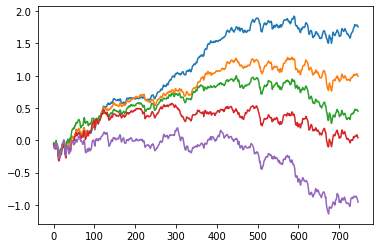

In [21]:
plt.plot(np.cumsum(retArr[:,1:],axis=0));

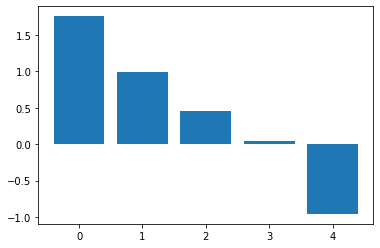

In [22]:
plt.bar(np.arange(retArr.shape[1]-1),np.sum(retArr[:,1:],axis=0));

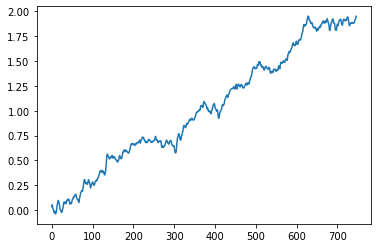

In [23]:
plt.plot(np.cumsum(retArr[:,2] - retArr[:,-1],axis=0));